# Module 3, assignment 1

# Intro
This assignment attempt to predict whether or not Trump tweets are genuine or produced by the https://faketrump.ai/ project.

The data used was given as part of the assignment.

## Preprocessing

#### Turning annoying warnings off.

In [0]:
# Filtering annmoying warning spam
from warnings import simplefilter
simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning,UserWarning,Warning))

#### Loading modules

In [110]:
## Loading modules
#
## NVidia GPU optimizer
!nvidia-smi

## Usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Keras & Co
import seaborn as sns
import keras
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.layers import Dense, LSTM, Dropout, Activation, Dense, Input, CuDNNLSTM, Embedding, Dropout, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.externals import joblib

Mon Nov 18 21:21:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    59W / 149W |   4339MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Fetching data and initial processing

In [111]:
# Fetch dataset
!wget -qq https://github.com/DeepLearnI/trump_tweet_classifier/raw/master/code/tweet_labels.csv -O df.csv
df = pd.read_csv('df.csv')
df['labels'].astype('uint8')
df.head(5)

,tweet,labels
0,To every one of the HEROES we recognized today...,True
1,We have been serving as policemen in Afghanist...,True
2,"...the Economy, where there is NO Recession, m...",True
3,"...the look of turmoil in the White House, of ...",True
4,A lot of Fake News is being reported that I ov...,True


Inspecting data

In [112]:
print(len(df))

15348


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15348 entries, 0 to 15347
Data columns (total 2 columns):
tweet     15348 non-null object
labels    15348 non-null bool
dtypes: bool(1), object(1)
memory usage: 135.0+ KB


In [114]:
df['labels'].value_counts()

True     8000
False    7348
Name: labels, dtype: int64

There is a fair amount of data as well as a fair distribution of 8000 to 7348 of true and false samples. So no problems regarding different sample representation is expected.

## Modeling

The problem is fairly complex and uses data that is not easy categorized, so no point in wasting time with simpler models. Straight to RNN

First tokenization and padding. A high vocabulary size is chosen since the tweets have been known to contain deliberate misspellings for political purposes. See "Covfefe". Paddig is set to 280 due to the max length of tweets.

In [0]:
## Tokenizing
vocabulary_size = 20000
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])

## Padding
mxl = 280
a = pad_sequences(sequences, maxlen=mxl)
indices = range(len(a))
b = df['labels']

Model building

For the split, a large test sample is selected because the data is very varied, and a plit with a small test sample is likely to contain patterns in the train set not includede in the test set due high variance.

During preliminary manual testing the 'Nadam' optimizer was found yielding the best results. Documentation can be found here: https://keras.io/optimizers/

In [116]:
## Split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(a, b, indices,  test_size=0.4)
embedding_vector_length = 500
## Initiation
model = Sequential()
## Layering
model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=mxl))
model.add(SpatialDropout1D(0.05))
model.add(CuDNNLSTM(24))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 280, 500)          10000000  
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 280, 500)          0         
_________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)    (None, 24)                50496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 24)                0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 24)                96        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 25        
Total params: 10,050,617
Trainable params: 10,050,569
Non-trainable params: 48
________________________________________

Let's see what accurracy we can expect.

In [117]:
acctest = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
print(acctest.history['val_loss'])
print(acctest.history['val_acc'])

Train on 9208 samples, validate on 6140 samples
Epoch 1/10
9208/9208 [==============================] - 22s 2ms/step - loss: 0.5716 - acc: 0.6849 - val_loss: 0.4826 - val_acc: 0.7594
Epoch 2/10
9208/9208 [==============================] - 17s 2ms/step - loss: 0.3214 - acc: 0.8604 - val_loss: 0.5301 - val_acc: 0.7516
Epoch 3/10
9208/9208 [==============================] - 17s 2ms/step - loss: 0.1790 - acc: 0.9328 - val_loss: 0.6872 - val_acc: 0.7280
Epoch 4/10
9208/9208 [==============================] - 17s 2ms/step - loss: 0.1122 - acc: 0.9581 - val_loss: 0.7796 - val_acc: 0.7482
Epoch 5/10
9208/9208 [==============================] - 17s 2ms/step - loss: 0.0781 - acc: 0.9732 - val_loss: 0.9080 - val_acc: 0.7539
Epoch 6/10
9208/9208 [==============================] - 17s 2ms/step - loss: 0.0614 - acc: 0.9791 - val_loss: 1.0447 - val_acc: 0.7352
Epoch 7/10
9208/9208 [==============================] - 17s 2ms/step - loss: 0.0422 - acc: 0.9865 - val_loss: 1.0902 - val_acc: 0.7388
Epoch 8

Accurracy is somewhere between 0,72 and 0,75

Loss is plotted to determine the optimal number of epocs.

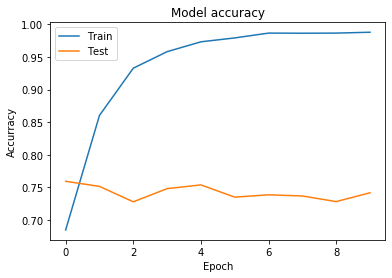

In [120]:
np.random.seed(1337)
plt.figure()
plt.plot(acctest.history['acc'])
plt.plot(acctest.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accurracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

Looks like 4 epochs is optimal.

Now let's refit the model and see what it can do.

In [121]:
model.fit(X_train, y_train, epochs=4, batch_size=24, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test)

Train on 9208 samples, validate on 6140 samples
Epoch 1/4
9208/9208 [==============================] - 23s 2ms/step - loss: 0.0313 - acc: 0.9900 - val_loss: 1.3474 - val_acc: 0.7469
Epoch 2/4
9208/9208 [==============================] - 23s 2ms/step - loss: 0.0305 - acc: 0.9896 - val_loss: 1.3149 - val_acc: 0.7476
Epoch 3/4
9208/9208 [==============================] - 23s 2ms/step - loss: 0.0231 - acc: 0.9927 - val_loss: 1.4295 - val_acc: 0.7443
Epoch 4/4
6140/6140 [==============================] - 3s 421us/step


[1.4186907180357444, 0.7485342019932277]

The model achieved an accurracy of 0.748. Meaning 74,8% of the times, the model will correctly determine whether or not a tweet is true or false.

While not a particular impressive result, due to time constraints the model will not be optimized further.

Thank you for reading and thank you for your time.